In [1]:
import random 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def loadEpisodes(fichier):
    """ Loads episodes in arrays """
    
    # Load the file
    with open(fichier, 'r') as f:
        episodes = []
        for episode in f.readlines():                                           # Read lines one by one
            episode = np.array([p.split(':')                                    # Remove the last ';' and split':'
                                for p in episode[:-2].split(';')], float)
            episode = np.array(episode, int)
            episode = episode[episode[:,1].argsort()]                           # Sort the array in order of the 
            episodes.append(episode)                                            # infection time 
        
    return episodes       

In [7]:
class IC():
    def __init__(self, episodes, nbIteration=10, nbSimulation=10):
        """ Algorithme IC (Independent Cascade)
            Setting up the inference mechanism and the learning algorithm of
            infections probabilities.
        """
        
        self.episodes = episodes                                                # Array of episodes
        self.nbIteration = nbIteration                                          # Nb Iterations for reaching convergence
        self.nbSimulation = nbSimulation                                        # Nb simulation of the inference
        self.nbUser = max([max(epi[:,0]) for epi in self.episodes]) + 1         # Nomber of users or distincts nodes
        self.predecessors = defaultdict(dict)                                   # Dictionary of predecessors for each user
        self.successors = defaultdict(dict)                                     # Dictionary of successors for each user
        self.dMoins = np.zeros((self.nbUser, self.nbUser))                      # Set of episodes D-
        self.dPlus = {(i,j):[] for i in range(0,self.nbUser)                    # Set of episodes D+
                      for j in range(0, self.nbUser)}
        self.likelyHoods = np.zeros(nbIteration)
        
    
    def createGraph(self):
        """ Creates the graph (tree) of episodes"""
        
        for episode in self.episodes:
            listeSuccessors = [episode[episode[:,1] > episode[i,1]][:,0]        # List of list of successors for each user
                                for i in range(len(episode))]   
            for i, successeur in enumerate(listeSuccessors):                    # for the list of successors of each user
                for v in successeur:                                            # for every successor of a user
                    u, proba = episode[i,0], np.random.random()                 # Generate a probability so within (0,1)
                    self.successors[u][v] = proba                               # u ---(proba)---> v 
                    self.predecessors[v][u] = proba                             # v ---(proba)---> u

        
    def ptD(self):
        """ Estimates each success probability """
        
        p = dict()
        for d, episode in enumerate(self.episodes):
            users, tempsU = episode[:,0], np.unique(episode[:,1])               # List of users of an episode and distinct
            p[d] = np.ones(self.nbUser)                                         # time            
            # Nb: Si on voulait connaitre le temps de l'infection, on aurait 
            # parcouru les temps.            
            for u, user in enumerate(users):
                ptd, hasPred = 1., False
                predU = episode[episode[:,1] < episode[u,1]][:,0]               # List of predecessors of user u at time tU
                for v in predU:                                                 # Proba que ça ne soit aucun des predecesseurs 
                    if v in self.predecessors[user]:                            # qui l'infectent
                        ptd *= (1 - self.successors[v][user])
                        hasPred = True
                if hasPred:
                    p[d][user] = 1 - ptd                                        # Proba que ça soit l'un deux, probleme line.

        return p

    
    def setOfdPlus(self):
        """ This method fills the set of episodes D+ which satisfies
            both u € D(t) and v € D(>t) """
        
        for d, episode in enumerate(self.episodes):
            for i in range(0,len(episode)):
                for j in range(0,len(episode)):
                    u, v = episode[i][0], episode[j][0]
                    tu, tv = episode[i][1], episode[j][1]
                    if u != v and tv > tu:                                      # If it's not the same user and v is infected
                        self.dPlus[u,v].append(d)                               # after u, then add the episode to the set
                        
    
    def setOfdMoins(self):
        """ This method fills the set of episodes D- which satisfies
            both u € D(t) and v not € D(t) """
        
        for episode in self.episodes:
            for i in range(0,len(episode)):
                for j in range(0, self.nbUser):
                    if (j not in episode[:,0]):
                        self.dMoins[episode[i][0]][j] += 1
                        

    def likelyhood(self, ptD):
        """ Calculate the likelyhood and returns it """
        
        vraissemblance = 0
        for d, episode in enumerate(self.episodes):
            vraissemblance += np.sum(np.log(ptD[d]))                            # Proba that the infected users get infected 
            users = episode[:,0]
            for u, user in enumerate(users):
                for v in range(self.nbUser):
                    if v not in users:
                        vraissemblance += np.log(1 - self.successors[user][v])  # Proba that the uninfected users stay uninfected
                        
        return vraissemblance

    
    def fit(self):
        """ Estimates each diffusion probability """
        
        self.createGraph()
        self.setOfdPlus()
        self.setOfdMoins()
        
        print("\nHeure de vérité, Vraissemblance:")
        print("================================")
        
        for i in range(0, self.nbIteration):
            p = self.ptD()
            self.likelyHoods[i] = self.likelyhood(p)
            
            print("It°{} : ".format(i+1), self.likelyHoods[i])

            for u in range(0, self.nbUser):
                for v in self.successors[u]:                                    # self.successors[u] is equivalent to self.nbUser
                    sumThetaPtd = 0                                             # in this case
                    sumDSets = len(self.dPlus[u,v]) + self.dMoins[u][v]         # D+(u,v) + D-(u,v)
                    for d in self.dPlus[u,v]:
                        sumThetaPtd += self.successors[u][v]/p[d][v]

                    self.successors[u][v] = sumThetaPtd/sumDSets
                    self.predecessors[v][u] = sumThetaPtd/sumDSets
                    
    
    def inference(self, S0):
        """ Chaque utilisateur tente d'infecter ses successeurs avec une
            probalité theta(u,v).
            :param S0: ensemble de sources, c a d, infecté au temps t0            
        """
        
        S = []
        infected = defaultdict(bool)
        S.append(S0)                                                            # We add users infected at time 0
        t = 1
        while S[t-1] != []:                                                     # While there's an uninfected user
            S.append([])
            for u in S[t-1]:
                for v in self.successors[u]:
                    if ((not infected[v]) and                                   # If the user is not infected and we have a 
                    (random.random() < self.successors[u][v])):                 # single chance (randomly) to infect him, then
                        infected[v] = True                                      # infect him.
                        S[t].append(v)
            t = t + 1
        return S, infected
        
        
    def predict(self, data):
        """ Applique l'inférence pendant nbIteration fois et considère la
            proportion d'infection de chaque utilisateur
        """
            
        sumInfected = defaultdict(float)
        for i in range(self.nbSimulation):
            s, infected = self.inference(data)
            for u in infected.keys():
                sumInfected[u] += infected[u]

        for u in sumInfected.keys():
            sumInfected[u] /= self.nbSimulation

        return sumInfected
        
    
    def score(self, data):
        """ Calcule la mésure de précision moyenne MAP """
        
        ic = IC(loadEpisodes(data))
        D = len(ic.episodes)
        sumD = 0
        for d, episode in enumerate(ic.episodes):
            users, tempsU = episode[:,0], np.unique(episode[:,1])
            sourcesS0 = users[[episode[:,1] == tempsU[0]]]                      # Infected user at (time 0) which is 1 in our data
            prediction = self.predict(sourcesS0)                                # Predict the proportion of infection of each user
            UD = np.array(list(prediction.keys()))[                             # knowing SO, then, Sort those probabilities 
                np.array(list(prediction.values())).argsort()[::-1]]            # in descending order
            sumI = 0
            lenEpisode = len(ic.episodes[d])
            for i in range(1, len(UD)):
                setOfUD = set(UD[1:i])                                          # first ième infected users in UD, which are UD[1:i]
                setOfD = set(ic.episodes[d][:,0])                               # The real infected users in the corresponding episode
                numerateur  = len(setOfUD & setOfD)                             # The intersection of the two sets
                sumI += numerateur / i                                         
            
            sumD += sumI / lenEpisode
            
        return sumD / D


In [22]:
def plotLikelyhood(ic):
    """ Plot the evoluation of x according to y """

    fig, ax = plt.subplots()

    plt.suptitle("Evolution of the likelyhood with IC model")
    ax.set_xlabel("nbIterations")
    ax.set_ylabel("likelyhoods")

    ax.plot(np.arange(ic.nbIteration), ic.likelyHoods,
            c='purple', marker='.', label="likelyhood")
    plt.legend()
    plt.show()


In [23]:
def main():
    """ We noticed that after each iteration, the values of theta decrease and
        MORE IMPORTANTLY, the likelyhood increases and converges after a certain
        number of iterations.
    """              

    train, test = "cascades_train.txt", "cascades_test.txt"
    
    ic = IC(loadEpisodes(train), nbIteration=10, nbSimulation=10)

    #------------------------------ Apprentissage -----------------------------#  
    ic.fit()
    theta = ic.successors[0]

    #print(theta)

    #------------------------------- Evaluation -------------------------------#
    scoreOn = test
    the_map = ic.score(test)
    
    print("\nScore MAP sur les données {} :\n".format(scoreOn), the_map)

    #---------------------- Plot the likelyhood evolution ---------------------#
    plotLikelyhood(ic)


Heure de vérité, Vraissemblance:
It°1 :  -5515659.67575
It°2 :  -428358.541415
It°3 :  -209275.3752
It°4 :  -200612.135543
It°5 :  -197642.735086
It°6 :  -195791.304683
It°7 :  -194622.153404
It°8 :  -193863.212952
It°9 :  -193353.147311
It°10 :  -192998.576715


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:131: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.



Score MAP sur les données cascades_test.txt :
 0.7181427053685903


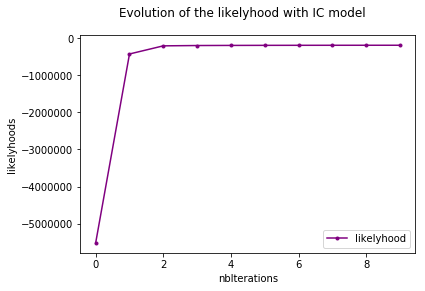

In [24]:
if __name__ == "__main__":
    main()